In [17]:
import pandas as pd
import numpy as np

import wrangle_zillow

import seaborn as sns
import matplotlib.pyplot as plt



from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

In [18]:
df = wrangle_zillow.get_zillow_data()
print(df.shape)

(77580, 68)


In [19]:
df = wrangle_zillow.get_single_unit_properties(df)
print(df.shape)

(52268, 68)


In [20]:
df = wrangle_zillow.remove_columns(df, cols_to_remove=["id", "propertylandusetypeid", "heatingorsystemtypeid", "propertyzoningdesc", "finishedsquarefeet12"])
print(df.shape)

(52268, 63)


In [21]:
df = wrangle_zillow.handle_missing_values(df)
print(df.shape)

(52268, 29)


In [22]:
 df = wrangle_zillow.impute_missing_values(df)
print(df.shape)

(52268, 29)


In [23]:
df = wrangle_zillow.remove_rows(df, cols_to_mask=["structuretaxvaluedollarcnt", "taxamount", "censustractandblock", "regionidzip"])
df.shape

(52152, 29)

# Outliers

> In the data science pipeline, we have determined that it is necessary to work with outliers after the data has been prepped but before imputation and scaling.  Issues that arose from working with outliers too early in the DS pipeline the same as working with unclean data
    - missing values
    - abundance of nan values
    - dtype issues
    
    
#### Squeeze vs Drop
We decided to squeeze outliers rather than drop them.
- Squeezing outliers does not affect the median or quantiles (quartiles for this project)
- For clustering it is reasonable to expect that a 49 million dollar house is similar to a 10 million dollar house

#### Median vs Mean 
In deciding between z-score (derived from mean) and IQR (derived from median).  We decided to work with **IQR**
- IQR will not change after we squeeze data
- As mean $\Delta$  $\therefore$   $\sigma$   $\therefore$  z-score will $\Delta$ as values in the columns $\Delta$ with squeezed data

#### Percentiles... how many outliers is reasonable?
Depending on the source what percintile of outliers is reasonable.  For normally distributed data: > 3 std above (or below) the mean should be less that .3% of the data.  Other sources mention that it is reasonable to have up to 10% of the data be considered outliers. 
- two new scipy.stats functions `percentileofscore`, `scoreatpercentile`
- we used at threshhold of 90% of data before it could be considered an outlier
- we used a threshold of 99.7% of data to stop increasing the IQR (from 1.5 to 3 to 5)

#### What did we do?
- determine if the column is numeric
- determine IQR with hyperparameter of: [1.5, 3, 5] (per classroom resources)
- determine # of outliers at each IQR
- determine # of data in outlier set at each IQR
- determine % of data in outlier set at each IQR
- chose which hyperparameter to use for outliers based on above conditions
- squeeze outliers to chosen IQR
- created new columns squeeze_[column_name]_IQR_[iqr_value]

#### Remaining work: visualizing outliers???

In [74]:
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile
# investigate nulls
df.shape, df.isnull().sum()

((52152, 29), parcelid                          0
 bathroomcnt                       0
 bedroomcnt                        0
 buildingqualitytypeid             0
 calculatedbathnbr                 0
 calculatedfinishedsquarefeet      0
 fips                              0
 fullbathcnt                       0
 latitude                          0
 longitude                         0
 lotsizesquarefeet                 0
 propertycountylandusecode         0
 rawcensustractandblock            0
 regionidcity                    999
 regionidcounty                    0
 regionidzip                       0
 roomcnt                           0
 unitcnt                           0
 yearbuilt                         0
 structuretaxvaluedollarcnt        0
 taxvaluedollarcnt                 0
 assessmentyear                    0
 landtaxvaluedollarcnt             0
 taxamount                         0
 censustractandblock               0
 logerror                          0
 transactiondate         

In [202]:
#determine if the column is numeric
def find_outlier_columns(df):
    """function takes in dataframe and returns list of column names:
    columns that are floats
    columns that are not categorical data values
    """
    outlier_columns = [x for x in df.columns if df[x].dtype == 'float64']
    outlier_columns.remove('longitude')
    outlier_columns.remove('latitude')
    for x in outlier_columns:
        y = len(df[x].value_counts())
        if y < 6:
            outlier_columns.remove(x)
        elif x.find('id') > 0:
            outlier_columns.remove(x)
    return outlier_columns


In [203]:
outlier_columns = find_outlier_columns(df)
outlier_columns


['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'lotsizesquarefeet',
 'rawcensustractandblock',
 'regionidcounty',
 'roomcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'logerror']

In [204]:
for x in outlier_columns:
    if x.find('id') > 0:
        print(x)

regionidcounty


In [205]:
#determine how many outliers in the column based on IQR at  1.5, 3 and 5
def choosing_IQR_value(df, list=outlier_columns):
    """function takes in a dataframe and a list of columns that will be searching for outliers"""
    value_list = []
    value_index_list = []
    perc_list = []
    for x in outlier_columns:
        IQR_1_5 = iqr(df[x]) * 1.5
        IQR_3 = iqr(df[x]) * 3
        IQR_5 = iqr(df[x]) * 5
        perc_IQR_1_5 = percentileofscore(df[x], score = IQR_1_5)
        perc_IQR_3 = percentileofscore(df[x], score = IQR_3)
        perc_IQR_5 = percentileofscore(df[x], score = IQR_5)
#         print (f"for {x}: IQRs are [{IQR_1_5 :.1f}, {IQR_3 :.1f}, {IQR_5 :.1f}], %s are [{perc_IQR_1_5 :.1f}, {perc_IQR_5 :.1f}, {perc_IQR_5 :.1f}]")
        if perc_IQR_1_5 > 99:
            value_list.append(IQR_1_5)
            value_index_list.append("1.5")
            perc_list.append(perc_IQR_1_5)
        elif perc_IQR_3 > 99:
            value_list.append(IQR_3)
            value_index_list.append("3")
            perc_list.append(perc_IQR_3)
        else:
            value_list.append(IQR_5)
            value_index_list.append("5")
            perc_list.append(perc_IQR_5)
#         else:
#             value_list.append(0)
#             value_index_list.append("0")
#             perc_list.append(0)
    return value_list, value_index_list, perc_list
        
#determine percentage of column that is outside the IQR at 1.5, 3 and 5

# 3 std above mean is 99.7% of data

In [206]:
value_list, value_index_list, perc_list = choosing_IQR_value(df, list=outlier_columns)

In [207]:
pd.DataFrame(data=(outlier_columns, value_list, value_index_list, perc_list)).transpose()

,0,1,2,3
0,bathroomcnt,5,5,97.7681
1,bedroomcnt,5,5,94.7289
2,calculatedbathnbr,5,5,97.77
3,calculatedfinishedsquarefeet,5175,5,98.7364
4,fullbathcnt,5,5,98.0202
5,lotsizesquarefeet,15777.5,5,91.4366
6,rawcensustractandblock,1.08206e+06,5,0
7,regionidcounty,5445,3,100
8,roomcnt,15,3,100
9,yearbuilt,145,5,0


SyntaxError: invalid syntax (<ipython-input-213-f0b1f4eff11a>, line 3)

In [ ]:
def squeeze_data(df, column)
    df['compare'] = threshold
    if df.compare > 
    df['squeeze_'[column]] 
    threshold = iqr(df[x])*5
        y = [n.replace(threshold) for n in x if n > threshold]
    return 

Text(0.5, 1.0, 'Problems with visualizing outliers in Historgram')

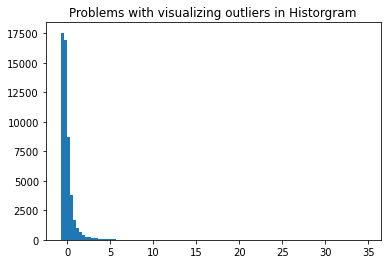

In [196]:
df.taxvaluedollarcnt.dropna(inplace=True)

plt.hist(zscore(df.taxvaluedollarcnt), bins=100)
plt.title('Problems with visualizing outliers in Historgram')

In [ ]:
sns.boxplot(zscore(df.taxvaluedollarcnt))
plt.title('Problems with visualizing outliers in BarPlot')